In [1]:
%matplotlib inline 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed
from graspy.inference import LatentDistributionTest
from graspy.align import SeedlessProcrustes, SignFlips
from graspy.utils import get_lcc
from graspy.plot import pairplot

In [2]:
# in this example, we generate two graphs from an SBM model with 
# B = [[0.9, 0.1], [0.1, 0.9]] n=100 and p = [0.5, 0.5].
# NOTE THAT CLASS MEMEBERSHIP IS SAMPLED!
def make_graphs(n=75):
    ns = (np.ones(3).astype(int) * n / 3).astype(int)
    P = [[0.20, 0.01, 0.01],
         [0.01, 0.10, 0.01],
         [0.01, 0.01, 0.20]]
    lcc = -1
    while lcc != n:
        A = sbm(ns, P)
        lcc = len(get_lcc(A))
    lcc = -1
    while lcc != n:
        B = sbm(ns, P)
        lcc = len(get_lcc(B))
    return A, B

In [3]:
# generate two graphs and embed them
n = 150
np.random.seed(123)
A, B = make_graphs(n=150)
ase = AdjacencySpectralEmbed(n_components=3)
X = ase.fit_transform(A)
Y = ase.fit_transform(B)

In [4]:
def _sign_flip_matrix_from_int(val_int, d):
    val_bin = bin(val_int)[2:]
    val_bin = "0" * (d - len(val_bin)) + val_bin
    return np.diag(np.array([(float(i) - 0.5) * -2 for i in val_bin]))

In [5]:
objectives = np.ones((8, 21))
for i in tqdm(range(8)):
    initial_Q_here = _sign_flip_matrix_from_int(i, 3)
    for k in range(21):
        # make an initial_Q
        aligner = SeedlessProcrustes(iterative_num_reps=k,
                                    init="custom",
                                    initial_Q=initial_Q_here).fit(X, Y)
        objectives[i, k] = aligner.score_

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


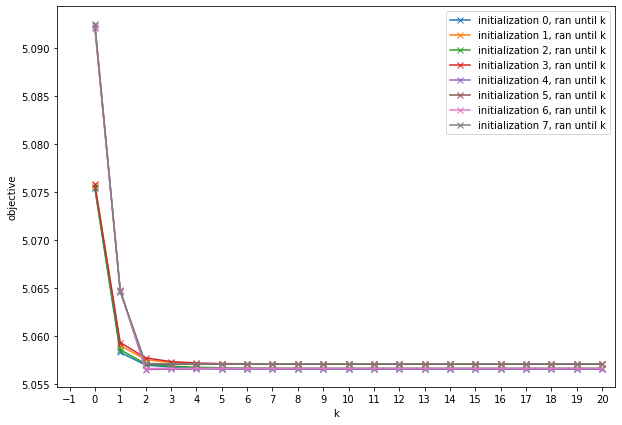

In [6]:
ignore = 0
plt.subplots(1, 1, figsize=(10, 7))
for i, vector in enumerate(objectives):
    plt.plot(np.arange(21)[ignore:],
                vector[ignore:],
                marker='x',
                label = f"initialization {i}, ran until k")
plt.ylabel("objective")
plt.xlabel("k")
plt.xlim(-1.5, 20.5)
plt.xticks(np.arange(22)-1);
plt.legend()
plt.savefig("all_trajectories_starting_0", bbox_inches="tight")

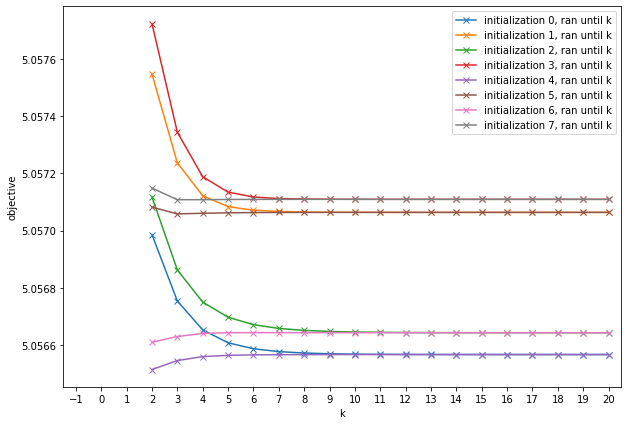

In [7]:
ignore = 2
plt.subplots(1, 1, figsize=(10, 7))
for i, vector in enumerate(objectives):
    plt.plot(np.arange(21)[ignore:],
                vector[ignore:],
                marker='x',
                label = f"initialization {i}, ran until k")
plt.ylabel("objective")
plt.xlabel("k")
plt.xlim(-1.5, 20.5)
plt.xticks(np.arange(22)-1);
plt.legend()
# plt.savefig("all_trajectories_starting_2", bbox_inches="tight")

In [8]:
# sketches starting here

5.056566152995606


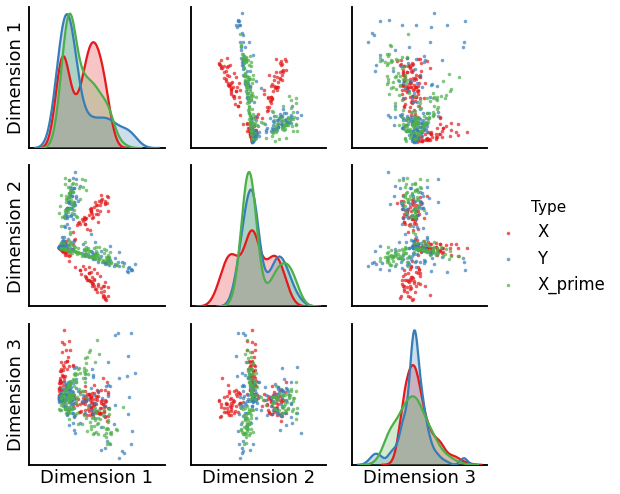

In [9]:
i = 0
initial_Q_here = _sign_flip_matrix_from_int(i, 3)
aligner = SeedlessProcrustes(iterative_num_reps=20,
                             init='custom',
                             initial_Q=initial_Q_here).fit(X, Y)
X_prime_1 = aligner.transform(X)
print(aligner.score_)
pairplot(np.concatenate([X, Y, X_prime_1]),
         labels = ['X']*150+['Y']*150+['X_prime']*150)

5.05710909474921


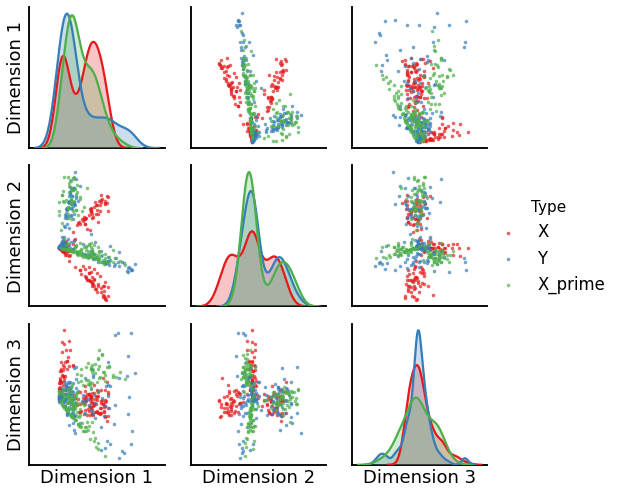

In [10]:
i = 3
initial_Q_here = _sign_flip_matrix_from_int(i, 3)
aligner = SeedlessProcrustes(iterative_num_reps=20,
                             init='custom',
                             initial_Q=initial_Q_here).fit(X, Y)
X_prime_2 = aligner.transform(X)
print(aligner.score_)
pairplot(np.concatenate([X, Y, X_prime_2]),
         labels = ['X']*150+['Y']*150+['X_prime']*150)

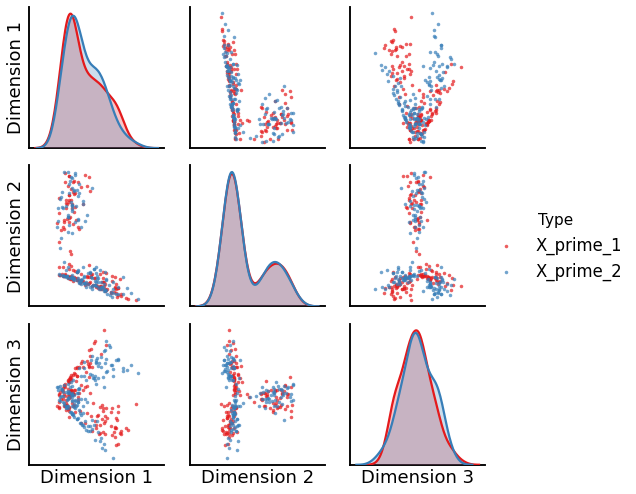

In [11]:
pairplot(np.concatenate([X_prime_1, X_prime_2]),
         labels = ['X_prime_1']*150+['X_prime_2']*150)

In [12]:
# try triaging

In [13]:
x = 20
n_ks = 21

score_over_2d = np.ones(n_ks) * (-1)
score_over_2d_until_x = np.ones(n_ks) * (-1)
initial_Qs = []

for k in tqdm(range(n_ks)):
    # run 2^d seeedlesss procrustes until k
    aligner_1 = SeedlessProcrustes(iterative_num_reps=k,
                                 init="2d").fit(X, Y)
    initial_Qs.append(aligner_1.initial_Q)
    score_over_2d[k] = aligner_1.score_
    # store the Q we started from 
    aligner_2 = SeedlessProcrustes(iterative_num_reps=x,
                                   init="custom",
                                   initial_Q=initial_Qs[-1]).fit(X, Y)
    score_over_2d_until_x[k] = aligner_2.score_

100%|██████████| 21/21 [00:03<00:00,  6.49it/s]


In [14]:
score_median_flip_until_x = SeedlessProcrustes(iterative_num_reps=x,
                                               init='sign_flips').fit(X,Y).score_
sign_flip_Q = SignFlips().fit(X, Y).Q_
score_median_flip = SeedlessProcrustes()._compute_objective(X, Y,
                                                            sign_flip_Q, 
                                                            np.ones((n, n))/(n**2))

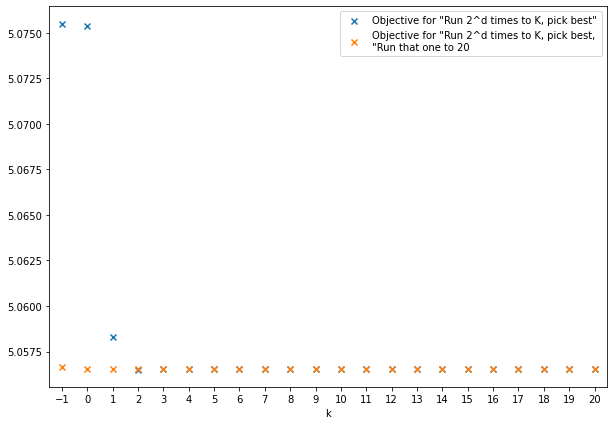

In [15]:
ignore = 0
plt.subplots(1, 1, figsize=(10, 7))
plt.scatter(np.arange(n_ks)[ignore:],
            score_over_2d[ignore:],
            marker='x',
            label='Objective for "Run 2^d times to K, pick best"')
plt.scatter(np.arange(n_ks)[ignore:],
            score_over_2d_until_x[ignore:],
            marker='x',
            label=('Objective for "Run 2^d times to K, pick best, \n"'
                   'Run that one to 20'))
plt.scatter([-1],
            score_median_flip,
            marker='x',
            color='C0')
plt.scatter([-1],
            score_median_flip_until_x,
            marker='x',
            color='C1')
plt.xlabel("k")
plt.xlim(-1.5, 20.5)
plt.xticks(np.arange(22)-1);
plt.legend()
# plt.savefig("do_not_ignore_frist.png", bbox_inches="tight")

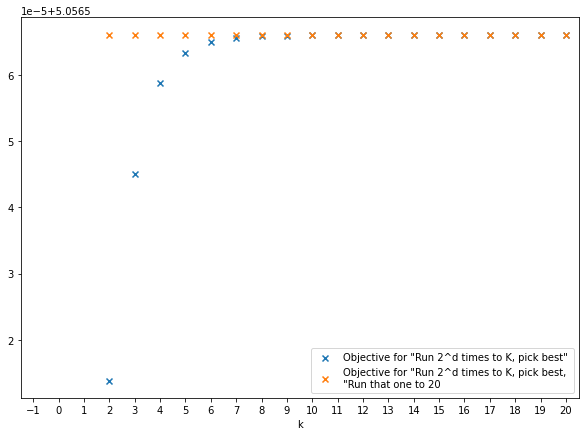

In [16]:
ignore = 2
plt.subplots(1, 1, figsize=(10, 7))
plt.scatter(np.arange(n_ks)[ignore:],
            score_over_2d[ignore:],
            marker='x',
            label='Objective for "Run 2^d times to K, pick best"')
plt.scatter(np.arange(n_ks)[ignore:],
            score_over_2d_until_x[ignore:],
            marker='x',
            label=('Objective for "Run 2^d times to K, pick best, \n"'
                   'Run that one to 20'))
if ignore < 1:
    plt.scatter([-1],
                score_median_flip,
                marker='x',
                color='C0')
    plt.scatter([-1],
                score_median_flip_until_x,
                marker='x',
                color='C1')
plt.xlabel("k")
plt.xlim(-1.5, 20.5)
plt.xticks(np.arange(22)-1);
plt.legend()
# plt.savefig("ignroe_frist.png", bbox_inches="tight")